In [1]:
#!pip install cloudant

In [2]:
#!pip install h2o

In [3]:
#!pip install scikit-learn --upgrade

In [4]:
#!pip install lightgbm --upgrade

In [5]:
#!pip install xgboost --upgrade

In [6]:
#!pip install imblearn --upgrade

In [7]:
#!pip install holidays

In [8]:
# Import de bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import date
from datetime import timedelta
import holidays

from sklearn.impute import SimpleImputer
from cloudant import Cloudant

from sklearn.model_selection import train_test_split

# Import dos módulos
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgbm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import warnings
warnings.filterwarnings("ignore")

In [9]:
# Definição das variáveis de conexão:

rodrigo = {'user': "",
           'password': "",
           'account': "",
           'db_name': ""
           }

In [10]:
# Funcao para carregar os dados do banco de dados NoSQL Cloudant
def obter_dados(user, password, account, db_name):

    client = Cloudant(user, password, account=account, connect=True, auto_renew=True)

    db = client[db_name]

    response = db.all_docs(limit=20000, include_docs=True)

    docs = []
    for r in response["rows"]:
        docs.append(r['doc'])

    return docs

# Verificando se existem registros duplicados no dataset
def verify_dup_rows(data):
    
    print("Linhas do dataset até o momento:")
    print(data.shape)

    # Obtendo somente linhas duplicadas
    tmp = data[data.duplicated()]

    print("\nLinhas duplicadas até o momento:")
    print(tmp.shape)
    
    del tmp
    
    
# Funcao para verificar valores missing no dataset
def check_missing(df, display = 10):
    temp_df = df.copy()
    df_nan = (temp_df.isnull().sum() / len(temp_df)) * 100
    missing_data = pd.DataFrame({'Missing n': temp_df.isnull().sum(),'% Missing' :df_nan})
    if missing_data['Missing n'].sum() == 0:
        return print('\nÓtimo! Não há mais valores faltantes neste dataset.')
    else:
        return missing_data.sort_values('% Missing', ascending = False).head(display)

# Funcao para preencher os dados missing de algumas colunas
def preenche_missing(df):
    
    df.dropna(axis='index', how='any', subset=['Tempo', 'Estação', 'LAT', 'LONG', 
                                               'Movimentação', 'Original_473', 
                                               'Original_269', 'Zero', 'Maçã-Verde', 
                                               'Tangerina', 'Citrus', 'Açaí-Guaraná', 
                                               'Pêssego'])

    # coloca constante 0 em outras colunas com dados missing
    impute_zeros = SimpleImputer(
                                    missing_values=np.nan,
                                    strategy='most_frequent',
                                    verbose=0,
                                    copy=True
                                )
    
    impute_zeros.fit(X=df)

    # Reconstruindo um Pandas DataFrame com os resultados
    data = pd.DataFrame.from_records(
            data = impute_zeros.transform(
            X    = df
        ),
        columns=df.columns
    )    
    
    # Converte colunas para numerico
    data = data.apply(pd.to_numeric, errors='ignore')

    return data

# Funcao para trabalhar as features
def fe(df, treino=True):

    if treino:
        
        # Transformando a coluna data
        df['Tempo'] = pd.to_datetime(df['Tempo'], errors='coerce')

        # Buscando os dias de feriados em SP no periodo
        #sp_holidays = holidays.CountryHoliday('BR', prov=None, state='SP')
        #sp_holidays[df['Tempo'].min(): df['Tempo'].max()]

        # Cria uma coluna de feriado
        #df['feriado'] = df['Tempo'].isin(sp_holidays).astype(int)

        # Removendo colunas unicas
        data = df.drop(['Tempo', 'LAT', 'LONG', 'Movimentação','Estação','_id', '_rev', 'row'], axis = 1)

        # Verificar os registros duplicados
        verify_dup_rows(data)

        # Removendo registros duplicados
        data = data.drop_duplicates().reset_index(drop=True)
    
    else:
        # Transformando a coluna data
        df['Tempo'] = pd.to_datetime(df['Tempo'], errors='coerce')
        
        # Removendo colunas unicas
        data = df.drop(['Tempo', 'LAT', 'LONG', 'Movimentação', 'Estação'], axis = 1)

    return data

# Funcao para transformar features categoricas em numericas
def fe_cat_num(df):

    # Tratando variáveis categóricas com o método Pandas ``get_dummies()''
    df = pd.get_dummies(df, columns=['Estação'])

    return df    

In [11]:
# Criando um dataframe a partir da lista de dados vindo do IoT e gravados no NoSQL do Walter:
train_walter = pd.DataFrame(data=obter_dados(walter['user'], walter['password'], walter['account'], walter['db_name']))
print(train_walter.shape)
train_walter.head()

(16853, 17)


,_id,_rev,Tempo,Estação,LAT,LONG,Movimentação,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET,row
0,01ad2da675f70d124acfe65acd00bbb7,1-440d9157bc05c0d49d7a80d4e4704691,2018-6-16,Luz,-23.5365,-46.6332,124909,86,54,37,17,6,12,31,15,REABASTECER,10966
1,01ad2da675f70d124acfe65acd023786,1-78c9d076126486a5b48c4b8ea3a9dda2,2018-9-5,Luz,-23.5365,-46.6332,125689,86,25,21,19,43,13,30,32,NORMAL,11045
2,01ad2da675f70d124acfe65acd053c63,1-50fca8a067246c52b150477ebc347722,2019-3-4,Luz,-23.5365,-46.6332,124910,43,11,24,32,33,14,23,21,NORMAL,11224
3,01ad2da675f70d124acfe65acd0693bd,1-3e0475d6843032ca4e3150ea24c3486c,2019-5-3,Luz,-23.5365,-46.6332,127059,86,7,21,32,12,37,40,27,NORMAL,11283
4,01ad2da675f70d124acfe65acd07a3ee,1-01db4b5752a4c809e6419b3e9f26b92c,2019-7-15,Luz,-23.5365,-46.6332,126558,86,35,11,32,19,8,3,25,NORMAL,11355


In [12]:
# Criando um dataframe a partir da lista de dados vindo do IoT e gravados no NoSQL do Rodrigo:
train_rodrigo = pd.DataFrame(data=obter_dados(rodrigo['user'], rodrigo['password'], rodrigo['account'], rodrigo['db_name']))
print(train_rodrigo.shape)
train_rodrigo.head()

(19550, 17)


,_id,_rev,Tempo,Estação,LAT,LONG,Movimentação,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET,row
0,01ad2da675f70d124acfe65acd01dab1,1-f7574b928d29d6e5001425ce9ca89218,2018-8-18,Luz,-23.5365,-46.6332,125065,86,11,12,24,25,10,15,17,NORMAL,11028
1,01ad2da675f70d124acfe65acd022669,1-d80039ae3de6035727a8f1156418e350,2018-9-2,Luz,-23.5365,-46.6332,124100,30,51,42,24,13,24,43,1,NORMAL,11042
2,01ad2da675f70d124acfe65acd047ea0,1-950cad7c11e47539c146b56193a2ab0a,2019-1-16,Luz,-23.5365,-46.6332,124034,86,14,24,42,37,22,23,33,NORMAL,11176
3,01ad2da675f70d124acfe65acd0b4cc4,1-896395b34f3ca616c82c9d3bfd344463,2018-2-17,Ana Rosa,-23.5813,-46.6383,66283,77,36,65,28,25,33,30,3,NORMAL,11567
4,01ad2da675f70d124acfe65acd0d5842,1-c82ec74abfcae1c44dfbb896b4d5dbe1,2018-5-8,Ana Rosa,-23.5813,-46.6383,67321,66,57,53,9,8,22,8,23,NORMAL,11648


In [13]:
# Concatenando as bases de dados:
train = pd.concat([train_walter, train_rodrigo], ignore_index=True)

In [14]:
# Criando um dataframe a partir da lista de dados vindo do IoT e gravados no NoSQL
#train = pd.DataFrame(data=obter_dados(user, password, account, db_name))


# Feature Engineering
treino = preenche_missing(train)    
treino = fe(treino, True) 
#treino = fe_cat_num(treino)

# Verificando as colunas com dados missing do dataset
check_missing(treino, display = 15)

print(treino.shape)

print('\n')


treino.head(10)

Linhas do dataset até o momento:
(36403, 9)

Linhas duplicadas até o momento:
(21037, 9)

Ótimo! Não há mais valores faltantes neste dataset.
(15366, 9)




,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
0,86,54,37,17,6,12,31,15,REABASTECER
1,86,25,21,19,43,13,30,32,NORMAL
2,43,11,24,32,33,14,23,21,NORMAL
3,86,7,21,32,12,37,40,27,NORMAL
4,86,35,11,32,19,8,3,25,NORMAL
5,28,15,51,7,43,18,5,33,NORMAL
6,27,58,35,22,32,29,29,4,REABASTECER
7,60,12,65,43,23,15,20,43,NORMAL
8,25,12,24,33,18,27,35,14,NORMAL
9,31,17,26,17,20,35,43,24,NORMAL


In [15]:
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 9 columns):
Original_473    15366 non-null int64
Original_269    15366 non-null int64
Zero            15366 non-null int64
Maçã-Verde      15366 non-null int64
Tangerina       15366 non-null int64
Citrus          15366 non-null int64
Açaí-Guaraná    15366 non-null int64
Pêssego         15366 non-null int64
TARGET          15366 non-null object
dtypes: int64(8), object(1)
memory usage: 1.1+ MB


In [16]:
#treino['feriado'].value_counts()

,TARGET,%
NORMAL,10372,67.5
REABASTECER,4994,32.5


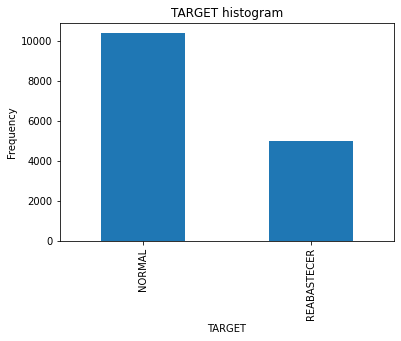

In [17]:
# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(treino['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(treino['TARGET'].value_counts())
tmp['%'] = round(100*tmp['TARGET']/tmp['TARGET'].sum(),3)
tmp

In [18]:
# Selecionando feature target
y = treino['TARGET']

# Selecionando features para treinamento
X = treino.drop(['TARGET'], axis = 1)

In [19]:
# Resolvendo problema de Overfitting utilizando o OverSampling

# Import dos módulos
from imblearn.over_sampling import SMOTE

# Aplicando a funcao SMOTE
# SMOTE eh um metodo de oversampling. Ele cria exemplos sinteticos da classe minoritaria ao inves de criar copias
sm = SMOTE(random_state=0)
_X, _y = sm.fit_sample(X, y)

Using TensorFlow backend.


In [20]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_gbc = GradientBoostingClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_gbc.predict(X_valid)

# Salvando o score
gbc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.95      0.70      0.81      2120
 REABASTECER       0.76      0.96      0.85      2029

    accuracy                           0.83      4149
   macro avg       0.86      0.83      0.83      4149
weighted avg       0.86      0.83      0.83      4149

F1_macro   :  0.8291571351999243
F1_micro   :  0.8312846469028682
F1_weighted:  0.8287389849516136
F1_none    :  [0.81009224 0.84822203]


In [21]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_lr = LogisticRegression().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_lr.predict(X_valid)

# Salvando o score
lr_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.64      0.63      0.64      2120
 REABASTECER       0.62      0.63      0.63      2029

    accuracy                           0.63      4149
   macro avg       0.63      0.63      0.63      4149
weighted avg       0.63      0.63      0.63      4149

F1_macro   :  0.6316751583297777
F1_micro   :  0.6317184863822608
F1_weighted:  0.6317627772803545
F1_none    :  [0.63567    0.62768031]


In [22]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_knn = KNeighborsClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_knn.predict(X_valid)

# Salvando o score
knn_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.80      0.68      0.74      2120
 REABASTECER       0.71      0.82      0.76      2029

    accuracy                           0.75      4149
   macro avg       0.76      0.75      0.75      4149
weighted avg       0.76      0.75      0.75      4149

F1_macro   :  0.7488329776774334
F1_micro   :  0.7495782116172571
F1_weighted:  0.7485329056043186
F1_none    :  [0.73515167 0.76251429]


In [23]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_dtc = DecisionTreeClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_dtc.predict(X_valid)

# Salvando o score
dtc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.79      0.77      0.78      2120
 REABASTECER       0.77      0.78      0.77      2029

    accuracy                           0.78      4149
   macro avg       0.78      0.78      0.78      4149
weighted avg       0.78      0.78      0.78      4149

F1_macro   :  0.7760606515365506
F1_micro   :  0.7760906242468064
F1_weighted:  0.776117474799744
F1_none    :  [0.77865142 0.77346989]


In [24]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_rfc = RandomForestClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_rfc.predict(X_valid)

# Salvando o score
rfc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.96      0.71      0.81      2120
 REABASTECER       0.76      0.97      0.85      2029

    accuracy                           0.83      4149
   macro avg       0.86      0.84      0.83      4149
weighted avg       0.86      0.83      0.83      4149

F1_macro   :  0.8328089368109299
F1_micro   :  0.8348999758978067
F1_weighted:  0.8323988407831155
F1_none    :  [0.81411126 0.85150661]


In [25]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_xgb = XGBClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_xgb.predict(X_valid)

# Salvando o score
xgb_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.91      0.74      0.82      2120
 REABASTECER       0.77      0.92      0.84      2029

    accuracy                           0.83      4149
   macro avg       0.84      0.83      0.83      4149
weighted avg       0.84      0.83      0.83      4149

F1_macro   :  0.8277327508594415
F1_micro   :  0.8286334056399133
F1_weighted:  0.8274595522426984
F1_none    :  [0.8152767  0.84018881]


In [26]:
# Prepara a lista de resultados
metricas = [(gbc_score),(lr_score),(knn_score),(dtc_score),(rfc_score),(xgb_score)]

# Cria o dataframe
df_metricas = pd.DataFrame(metricas, 
                           columns = ['Accuracy'], 
                           index = ['GBC', 'LR', 'KNN', 'DTC', 'RFC', 'XGB']) 

# Visualiza o resultado
df_metricas

,Accuracy
GBC,0.828739
LR,0.631763
KNN,0.748533
DTC,0.776117
RFC,0.832399
XGB,0.827460


# AUTOML com H20

In [27]:
# Importando as bibliotecas
import h2o
from h2o.automl import H2OAutoML

# Inicializando o cluster
h2o.init()
h2o.cluster().show_status()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,19 days 21 hours 34 mins
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_unimed_arnacy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,13.27 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


H2O_cluster_uptime:,19 days 21 hours 34 mins
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_unimed_arnacy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,13.27 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [28]:
# Importando os datasets   
df_treino = h2o.H2OFrame(treino)

# Convertendo a coluna target em fator
df_treino['TARGET'] = df_treino['TARGET'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [29]:
df_treino.head()

Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
86,54,37,17,6,12,31,15,REABASTECER
86,25,21,19,43,13,30,32,NORMAL
43,11,24,32,33,14,23,21,NORMAL
86,7,21,32,12,37,40,27,NORMAL
86,35,11,32,19,8,3,25,NORMAL
28,15,51,7,43,18,5,33,NORMAL
27,58,35,22,32,29,29,4,REABASTECER
60,12,65,43,23,15,20,43,NORMAL
25,12,24,33,18,27,35,14,NORMAL
31,17,26,17,20,35,43,24,NORMAL


# Treinamento sem balanceamento

In [30]:
# Indicando as colunas preditoras e a target
X = df_treino.drop(['TARGET'], axis = 1).columns
y = 'TARGET'

# Executa o AutoML para 20 modelos
aml = H2OAutoML(max_models=20, seed=133, balance_classes=False, verbosity='info')
aml.train(x=X, y=y, training_frame=df_treino)

AutoML progress: |
20:20:01.552: Project: AutoML_20200906_202001552
20:20:01.552: Setting stopping tolerance adaptively based on the training frame: 0.008067139845186208
20:20:01.552: Build control seed: 133
20:20:01.552: training frame: Frame key: automl_training_py_1_sid_bddb    cols: 9    rows: 15366  chunks: 1    size: 126045  checksum: -242599085861816
20:20:01.552: validation frame: NULL
20:20:01.552: leaderboard frame: NULL
20:20:01.552: blending frame: NULL
20:20:01.552: response column: TARGET
20:20:01.552: fold column: null
20:20:01.552: weights column: null
20:20:01.553: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
20:20:01.553: AutoML job created: 2020.09.06 20:20:01.552
20:20:01.559: AutoML build started: 2020.09.06 20:20:01.559
20:20:01.559:

H2OJobCancelled: Job<$03017f00000132d4ffffffff$_8d0f826ea1271e77d1ee7dd2626b4298> was cancelled by the user.

In [ ]:
# AutoML Leaderboard
lb = aml.leaderboard

# Exibir as colunas do resultado dos modelos
lb.head(rows=lb.nrows)

In [ ]:
# Detalhes do melhor modelo
aml.leader

# Treinamento com balanceamento

In [ ]:
# Indicando as colunas preditoras e a target
X = df_treino.drop(['TARGET'], axis = 1).columns
y = 'TARGET'

# Executa o AutoML para 20 modelos
aml2 = H2OAutoML(max_models=20, seed=133, balance_classes=True, verbosity='info')
aml2.train(x=X, y=y, training_frame=df_treino)

In [ ]:
# AutoML Leaderboard
lb2 = aml2.leaderboard

# Exibir as colunas do resultado dos modelos
lb2.head(rows=lb2.nrows)

In [ ]:
# Detalhes do melhor modelo
aml2.leader

# Realizando as previsoes em Teste

In [ ]:
# Carregando o dataset de testes 
test  = pd.read_csv(r'teste_desafio_7.csv')

# Feature Engineering
teste = preenche_missing(test)    
teste = fe(teste, False)   

# Verificando as colunas com dados missing do dataset
check_missing(teste, display = 15)

print(teste.shape)

print('\n')


teste.head(10)

In [ ]:
df_teste = h2o.H2OFrame(teste)

# SEM BALANCEAMENTO

In [ ]:
# Gerar as previsoes no dataset de teste
preds = aml.leader.predict(df_teste)

# Salvar o resultado no dataset de teste
result = preds[:,0]
df_teste['TARGET'] = result

# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(df_teste['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(df_teste['TARGET'].value_counts())
tmp['%'] = round(100*tmp['TARGET']/tmp['TARGET'].sum(),3)
tmp

# COM BALANCEAMENTO

In [ ]:
# Gerar as previsoes no dataset de teste
preds = aml2.leader.predict(df_teste)

# Salvar o resultado no dataset de teste
result = preds[:,0]
df_teste['TARGET'] = result

# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(df_teste['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(df_teste['TARGET'].value_counts())
tmp['%'] = round(100*tmp['TARGET']/tmp['TARGET'].sum(),3)
tmp

In [ ]:
# Gravar o arquivo de submissão ao Desafio
#h2o.export_file(df_teste,'results_desafio_7.csv')